# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Neural Network class

* Generator
* Discriminator


In [2]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(20,400)
        self.fc2 =nn.Linear(400,784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):
        h=F.relu(self.fc1(z)).to(device)
        probabilities=torch.sigmoid(self.fc2(h)).to(device)
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 =nn.Linear(400,1)
    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        h=F.relu(self.fc1(x.view(-1, 784))).to(device)
        probabilities = torch.sigmoid(self.fc2(h)).to(device)
        return probabilities

# Loss Function

In [3]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):
    BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE

# Training

In [4]:
# GAN Training
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    Disc_Loss_Sum = 0
    Gen_Loss_Sum =0
    real_label = 1.
    fake_label = 0.    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        discriminator_optimizer.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_cpu).view(-1)
        Disc_Real_Loss = gan_loss_function(output, label)
        Disc_Real_Loss.backward()

        noise = torch.randn(b_size, 20, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        Disc_Fake_Loss = gan_loss_function(output, label)
        Disc_Fake_Loss.backward()
        ax = Disc_Fake_Loss.item()+Disc_Real_Loss.item()
        Disc_Loss_Sum += ax
        discriminator_optimizer.step()
        generator_optimizer.zero_grad()
        label.fill_(real_label) 
        output = discriminator(fake).view(-1)
        Gen_Loss = gan_loss_function(output, label)
        Gen_Loss.backward()
        Gen_Loss_Sum += Gen_Loss.item()
        generator_optimizer.step()
        if (batch_idx % log_interval == 0) & (batch_idx > 0):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tDisc_Loss_Avg: {:.6f}\tGen_Loss_Avg: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader),
              Disc_Loss_Sum /(1+batch_idx * len(data)), Gen_Loss_Sum / (1+batch_idx * len(data))))
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tDisc_Loss_Avg: {:.6f}\tGen_Loss_Avg: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader),
            Disc_Loss_Sum /(1+batch_idx * len(data)), Gen_Loss_Sum / (1+batch_idx * len(data))))    
    average_discriminator_loss = Disc_Loss_Sum / len(train_loader.dataset)
    average_generator_loss = Gen_Loss_Sum/ len(train_loader.dataset)
    return average_generator_loss, average_discriminator_loss


# Testing


In [5]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    generator.eval()
    discriminator.eval()
    Disc_Loss_Sum = 0
    Gen_Loss_Sum = 0
    real_label = 1.
    fake_label = 0.
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            output = discriminator(real_cpu).view(-1)
            Disc_Real_Loss = gan_loss_function(output, label) 
            noise = torch.randn(b_size, 20, device=device)
            fake = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake.detach()).view(-1)
            Disc_Fake_Loss = gan_loss_function(output, label)
            ax = (Disc_Fake_Loss.item())+(Disc_Real_Loss.item())
            Disc_Loss_Sum += ax
            label.fill_(real_label) 
            output = discriminator(fake).view(-1)
            Gen_Loss = gan_loss_function(output, label)
            Gen_Loss_Sum += Gen_Loss.item()
    average_generator_loss = Gen_Loss_Sum / len(test_loader.dataset)
    average_discriminator_loss = Disc_Loss_Sum / len(test_loader.dataset)
    print('====> Test set Generate_Loss: {:.4f}'.format(average_generator_loss))
    print('====> Test set Discriminator_Loss: {:.4f}'.format(average_discriminator_loss))
    return average_generator_loss, average_discriminator_loss

# Main

Train Epoch: 1 [12800/60000 (21%)]	Disc_Loss_Avg: 0.005891	Gen_Loss_Avg: 0.020125
Train Epoch: 1 [25600/60000 (43%)]	Disc_Loss_Avg: 0.004784	Gen_Loss_Avg: 0.019098
Train Epoch: 1 [38400/60000 (64%)]	Disc_Loss_Avg: 0.003654	Gen_Loss_Avg: 0.021362
Train Epoch: 1 [51200/60000 (85%)]	Disc_Loss_Avg: 0.003032	Gen_Loss_Avg: 0.022931
Train Epoch: 1 [44928/60000 (100%)]	Disc_Loss_Avg: 0.003665	Gen_Loss_Avg: 0.032206
====> Test set Generate_Loss: 0.0291
====> Test set Discriminator_Loss: 0.0004
Sample of generated images


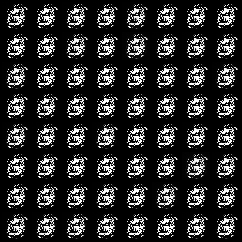



Train Epoch: 2 [12800/60000 (21%)]	Disc_Loss_Avg: 0.000666	Gen_Loss_Avg: 0.040298
Train Epoch: 2 [25600/60000 (43%)]	Disc_Loss_Avg: 0.000656	Gen_Loss_Avg: 0.039485
Train Epoch: 2 [38400/60000 (64%)]	Disc_Loss_Avg: 0.000651	Gen_Loss_Avg: 0.040913
Train Epoch: 2 [51200/60000 (85%)]	Disc_Loss_Avg: 0.001095	Gen_Loss_Avg: 0.044845
Train Epoch: 2 [44928/60000 (100%)]	Disc_Loss_Avg: 0.001964	Gen_Loss_Avg: 0.062259
====> Test set Generate_Loss: 0.0455
====> Test set Discriminator_Loss: 0.0003
Sample of generated images


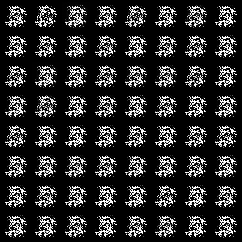



Train Epoch: 3 [12800/60000 (21%)]	Disc_Loss_Avg: 0.000427	Gen_Loss_Avg: 0.048952
Train Epoch: 3 [25600/60000 (43%)]	Disc_Loss_Avg: 0.000856	Gen_Loss_Avg: 0.046786
Train Epoch: 3 [38400/60000 (64%)]	Disc_Loss_Avg: 0.001098	Gen_Loss_Avg: 0.045816
Train Epoch: 3 [51200/60000 (85%)]	Disc_Loss_Avg: 0.001223	Gen_Loss_Avg: 0.047191
Train Epoch: 3 [44928/60000 (100%)]	Disc_Loss_Avg: 0.001703	Gen_Loss_Avg: 0.062388
====> Test set Generate_Loss: 0.0418
====> Test set Discriminator_Loss: 0.0011
Sample of generated images


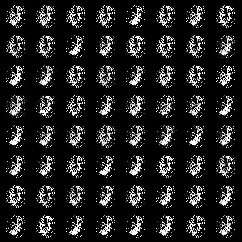



Train Epoch: 4 [12800/60000 (21%)]	Disc_Loss_Avg: 0.001346	Gen_Loss_Avg: 0.041529
Train Epoch: 4 [25600/60000 (43%)]	Disc_Loss_Avg: 0.001251	Gen_Loss_Avg: 0.038952
Train Epoch: 4 [38400/60000 (64%)]	Disc_Loss_Avg: 0.001126	Gen_Loss_Avg: 0.035888
Train Epoch: 4 [51200/60000 (85%)]	Disc_Loss_Avg: 0.001201	Gen_Loss_Avg: 0.035348
Train Epoch: 4 [44928/60000 (100%)]	Disc_Loss_Avg: 0.001670	Gen_Loss_Avg: 0.046336
====> Test set Generate_Loss: 0.0165
====> Test set Discriminator_Loss: 0.0021
Sample of generated images


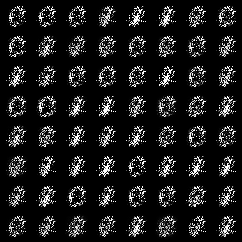



Train Epoch: 5 [12800/60000 (21%)]	Disc_Loss_Avg: 0.001294	Gen_Loss_Avg: 0.030988
Train Epoch: 5 [25600/60000 (43%)]	Disc_Loss_Avg: 0.001039	Gen_Loss_Avg: 0.031710
Train Epoch: 5 [38400/60000 (64%)]	Disc_Loss_Avg: 0.001000	Gen_Loss_Avg: 0.032879
Train Epoch: 5 [51200/60000 (85%)]	Disc_Loss_Avg: 0.001007	Gen_Loss_Avg: 0.034648
Train Epoch: 5 [44928/60000 (100%)]	Disc_Loss_Avg: 0.001311	Gen_Loss_Avg: 0.046963
====> Test set Generate_Loss: 0.0235
====> Test set Discriminator_Loss: 0.0024
Sample of generated images


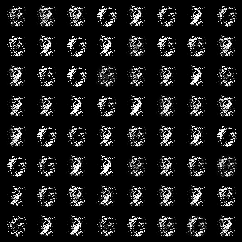



Train Epoch: 6 [12800/60000 (21%)]	Disc_Loss_Avg: 0.001580	Gen_Loss_Avg: 0.035417
Train Epoch: 6 [25600/60000 (43%)]	Disc_Loss_Avg: 0.001192	Gen_Loss_Avg: 0.034233
Train Epoch: 6 [38400/60000 (64%)]	Disc_Loss_Avg: 0.001062	Gen_Loss_Avg: 0.033168
Train Epoch: 6 [51200/60000 (85%)]	Disc_Loss_Avg: 0.000993	Gen_Loss_Avg: 0.032897
Train Epoch: 6 [44928/60000 (100%)]	Disc_Loss_Avg: 0.001259	Gen_Loss_Avg: 0.044566
====> Test set Generate_Loss: 0.0393
====> Test set Discriminator_Loss: 0.0007
Sample of generated images


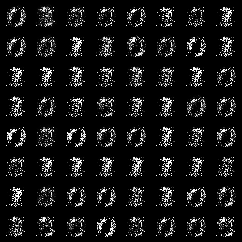



Train Epoch: 7 [12800/60000 (21%)]	Disc_Loss_Avg: 0.001100	Gen_Loss_Avg: 0.036740
Train Epoch: 7 [25600/60000 (43%)]	Disc_Loss_Avg: 0.001432	Gen_Loss_Avg: 0.033998
Train Epoch: 7 [38400/60000 (64%)]	Disc_Loss_Avg: 0.001531	Gen_Loss_Avg: 0.033589
Train Epoch: 7 [51200/60000 (85%)]	Disc_Loss_Avg: 0.001814	Gen_Loss_Avg: 0.032165
Train Epoch: 7 [44928/60000 (100%)]	Disc_Loss_Avg: 0.002518	Gen_Loss_Avg: 0.041505
====> Test set Generate_Loss: 0.0179
====> Test set Discriminator_Loss: 0.0040
Sample of generated images


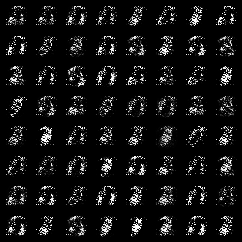



Train Epoch: 8 [12800/60000 (21%)]	Disc_Loss_Avg: 0.001580	Gen_Loss_Avg: 0.028684
Train Epoch: 8 [25600/60000 (43%)]	Disc_Loss_Avg: 0.002229	Gen_Loss_Avg: 0.026673
Train Epoch: 8 [38400/60000 (64%)]	Disc_Loss_Avg: 0.002785	Gen_Loss_Avg: 0.024769
Train Epoch: 8 [51200/60000 (85%)]	Disc_Loss_Avg: 0.002512	Gen_Loss_Avg: 0.025085
Train Epoch: 8 [44928/60000 (100%)]	Disc_Loss_Avg: 0.003380	Gen_Loss_Avg: 0.033369
====> Test set Generate_Loss: 0.0185
====> Test set Discriminator_Loss: 0.0026
Sample of generated images


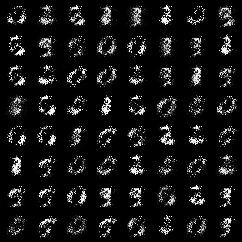



Train Epoch: 9 [12800/60000 (21%)]	Disc_Loss_Avg: 0.002289	Gen_Loss_Avg: 0.024077
Train Epoch: 9 [25600/60000 (43%)]	Disc_Loss_Avg: 0.002055	Gen_Loss_Avg: 0.025416
Train Epoch: 9 [38400/60000 (64%)]	Disc_Loss_Avg: 0.002599	Gen_Loss_Avg: 0.024868
Train Epoch: 9 [51200/60000 (85%)]	Disc_Loss_Avg: 0.002480	Gen_Loss_Avg: 0.025084
Train Epoch: 9 [44928/60000 (100%)]	Disc_Loss_Avg: 0.003368	Gen_Loss_Avg: 0.033266
====> Test set Generate_Loss: 0.0313
====> Test set Discriminator_Loss: 0.0051
Sample of generated images


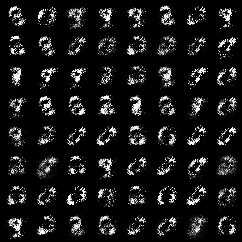



Train Epoch: 10 [12800/60000 (21%)]	Disc_Loss_Avg: 0.003311	Gen_Loss_Avg: 0.024891
Train Epoch: 10 [25600/60000 (43%)]	Disc_Loss_Avg: 0.003434	Gen_Loss_Avg: 0.025937
Train Epoch: 10 [38400/60000 (64%)]	Disc_Loss_Avg: 0.003580	Gen_Loss_Avg: 0.025725
Train Epoch: 10 [51200/60000 (85%)]	Disc_Loss_Avg: 0.003827	Gen_Loss_Avg: 0.025647
Train Epoch: 10 [44928/60000 (100%)]	Disc_Loss_Avg: 0.005263	Gen_Loss_Avg: 0.033785
====> Test set Generate_Loss: 0.0358
====> Test set Discriminator_Loss: 0.0053
Sample of generated images


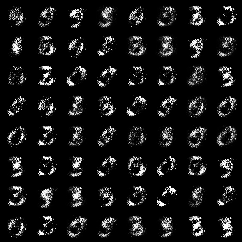



Train Epoch: 11 [12800/60000 (21%)]	Disc_Loss_Avg: 0.003856	Gen_Loss_Avg: 0.023862
Train Epoch: 11 [25600/60000 (43%)]	Disc_Loss_Avg: 0.004150	Gen_Loss_Avg: 0.022949
Train Epoch: 11 [38400/60000 (64%)]	Disc_Loss_Avg: 0.004031	Gen_Loss_Avg: 0.022522
Train Epoch: 11 [51200/60000 (85%)]	Disc_Loss_Avg: 0.003732	Gen_Loss_Avg: 0.022111
Train Epoch: 11 [44928/60000 (100%)]	Disc_Loss_Avg: 0.005133	Gen_Loss_Avg: 0.029591
====> Test set Generate_Loss: 0.0113
====> Test set Discriminator_Loss: 0.0087
Sample of generated images


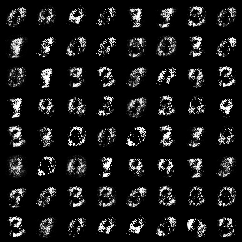



Train Epoch: 12 [12800/60000 (21%)]	Disc_Loss_Avg: 0.003860	Gen_Loss_Avg: 0.022213
Train Epoch: 12 [25600/60000 (43%)]	Disc_Loss_Avg: 0.004360	Gen_Loss_Avg: 0.020810
Train Epoch: 12 [38400/60000 (64%)]	Disc_Loss_Avg: 0.004275	Gen_Loss_Avg: 0.020638
Train Epoch: 12 [51200/60000 (85%)]	Disc_Loss_Avg: 0.003951	Gen_Loss_Avg: 0.020952
Train Epoch: 12 [44928/60000 (100%)]	Disc_Loss_Avg: 0.005425	Gen_Loss_Avg: 0.028028
====> Test set Generate_Loss: 0.0260
====> Test set Discriminator_Loss: 0.0045
Sample of generated images


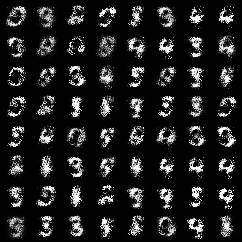



Train Epoch: 13 [12800/60000 (21%)]	Disc_Loss_Avg: 0.004472	Gen_Loss_Avg: 0.024186
Train Epoch: 13 [25600/60000 (43%)]	Disc_Loss_Avg: 0.004473	Gen_Loss_Avg: 0.023273
Train Epoch: 13 [38400/60000 (64%)]	Disc_Loss_Avg: 0.004313	Gen_Loss_Avg: 0.021837
Train Epoch: 13 [51200/60000 (85%)]	Disc_Loss_Avg: 0.004571	Gen_Loss_Avg: 0.021644
Train Epoch: 13 [44928/60000 (100%)]	Disc_Loss_Avg: 0.006518	Gen_Loss_Avg: 0.027994
====> Test set Generate_Loss: 0.0155
====> Test set Discriminator_Loss: 0.0054
Sample of generated images


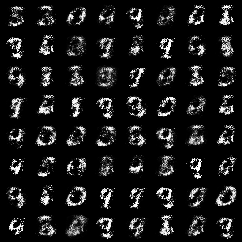



Train Epoch: 14 [12800/60000 (21%)]	Disc_Loss_Avg: 0.005553	Gen_Loss_Avg: 0.015695
Train Epoch: 14 [25600/60000 (43%)]	Disc_Loss_Avg: 0.005911	Gen_Loss_Avg: 0.016197
Train Epoch: 14 [38400/60000 (64%)]	Disc_Loss_Avg: 0.005642	Gen_Loss_Avg: 0.016199
Train Epoch: 14 [51200/60000 (85%)]	Disc_Loss_Avg: 0.005494	Gen_Loss_Avg: 0.016169
Train Epoch: 14 [44928/60000 (100%)]	Disc_Loss_Avg: 0.007474	Gen_Loss_Avg: 0.021656
====> Test set Generate_Loss: 0.0145
====> Test set Discriminator_Loss: 0.0049
Sample of generated images


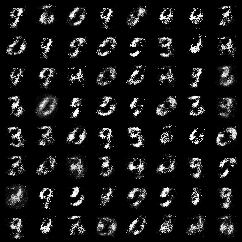



Train Epoch: 15 [12800/60000 (21%)]	Disc_Loss_Avg: 0.005413	Gen_Loss_Avg: 0.015166
Train Epoch: 15 [25600/60000 (43%)]	Disc_Loss_Avg: 0.004993	Gen_Loss_Avg: 0.015713
Train Epoch: 15 [38400/60000 (64%)]	Disc_Loss_Avg: 0.004995	Gen_Loss_Avg: 0.015879
Train Epoch: 15 [51200/60000 (85%)]	Disc_Loss_Avg: 0.005185	Gen_Loss_Avg: 0.015741
Train Epoch: 15 [44928/60000 (100%)]	Disc_Loss_Avg: 0.006899	Gen_Loss_Avg: 0.021095
====> Test set Generate_Loss: 0.0175
====> Test set Discriminator_Loss: 0.0046
Sample of generated images


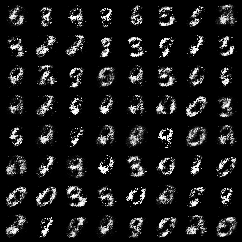



Train Epoch: 16 [12800/60000 (21%)]	Disc_Loss_Avg: 0.004813	Gen_Loss_Avg: 0.018133
Train Epoch: 16 [25600/60000 (43%)]	Disc_Loss_Avg: 0.005589	Gen_Loss_Avg: 0.017106
Train Epoch: 16 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006055	Gen_Loss_Avg: 0.016804
Train Epoch: 16 [51200/60000 (85%)]	Disc_Loss_Avg: 0.005799	Gen_Loss_Avg: 0.016768
Train Epoch: 16 [44928/60000 (100%)]	Disc_Loss_Avg: 0.007561	Gen_Loss_Avg: 0.021922
====> Test set Generate_Loss: 0.0117
====> Test set Discriminator_Loss: 0.0064
Sample of generated images


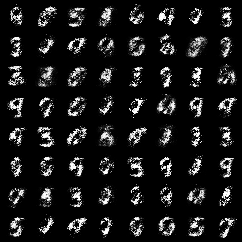



Train Epoch: 17 [12800/60000 (21%)]	Disc_Loss_Avg: 0.005556	Gen_Loss_Avg: 0.014996
Train Epoch: 17 [25600/60000 (43%)]	Disc_Loss_Avg: 0.005471	Gen_Loss_Avg: 0.015819
Train Epoch: 17 [38400/60000 (64%)]	Disc_Loss_Avg: 0.005575	Gen_Loss_Avg: 0.016054
Train Epoch: 17 [51200/60000 (85%)]	Disc_Loss_Avg: 0.005613	Gen_Loss_Avg: 0.015668
Train Epoch: 17 [44928/60000 (100%)]	Disc_Loss_Avg: 0.007555	Gen_Loss_Avg: 0.020954
====> Test set Generate_Loss: 0.0116
====> Test set Discriminator_Loss: 0.0080
Sample of generated images


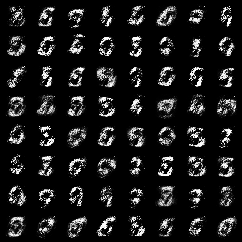



Train Epoch: 18 [12800/60000 (21%)]	Disc_Loss_Avg: 0.004970	Gen_Loss_Avg: 0.016592
Train Epoch: 18 [25600/60000 (43%)]	Disc_Loss_Avg: 0.005243	Gen_Loss_Avg: 0.016127
Train Epoch: 18 [38400/60000 (64%)]	Disc_Loss_Avg: 0.005238	Gen_Loss_Avg: 0.015926
Train Epoch: 18 [51200/60000 (85%)]	Disc_Loss_Avg: 0.005819	Gen_Loss_Avg: 0.015961
Train Epoch: 18 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008036	Gen_Loss_Avg: 0.021483
====> Test set Generate_Loss: 0.0191
====> Test set Discriminator_Loss: 0.0048
Sample of generated images


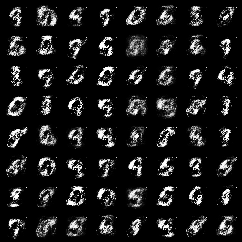



Train Epoch: 19 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006598	Gen_Loss_Avg: 0.017002
Train Epoch: 19 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006281	Gen_Loss_Avg: 0.017116
Train Epoch: 19 [38400/60000 (64%)]	Disc_Loss_Avg: 0.005947	Gen_Loss_Avg: 0.017063
Train Epoch: 19 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006031	Gen_Loss_Avg: 0.016832
Train Epoch: 19 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008497	Gen_Loss_Avg: 0.022514
====> Test set Generate_Loss: 0.0097
====> Test set Discriminator_Loss: 0.0070
Sample of generated images


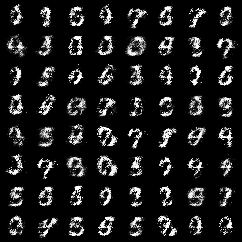



Train Epoch: 20 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007331	Gen_Loss_Avg: 0.015358
Train Epoch: 20 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007754	Gen_Loss_Avg: 0.014650
Train Epoch: 20 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007010	Gen_Loss_Avg: 0.016024
Train Epoch: 20 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007090	Gen_Loss_Avg: 0.015463
Train Epoch: 20 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009427	Gen_Loss_Avg: 0.020512
====> Test set Generate_Loss: 0.0199
====> Test set Discriminator_Loss: 0.0055
Sample of generated images


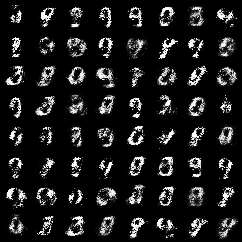



Train Epoch: 21 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007731	Gen_Loss_Avg: 0.016529
Train Epoch: 21 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007623	Gen_Loss_Avg: 0.015317
Train Epoch: 21 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007503	Gen_Loss_Avg: 0.014973
Train Epoch: 21 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007002	Gen_Loss_Avg: 0.015356
Train Epoch: 21 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009316	Gen_Loss_Avg: 0.020400
====> Test set Generate_Loss: 0.0161
====> Test set Discriminator_Loss: 0.0076
Sample of generated images


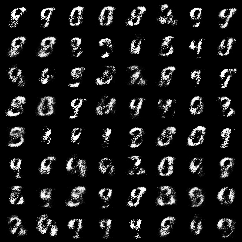



Train Epoch: 22 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007312	Gen_Loss_Avg: 0.013574
Train Epoch: 22 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006244	Gen_Loss_Avg: 0.013761
Train Epoch: 22 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006319	Gen_Loss_Avg: 0.014164
Train Epoch: 22 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006618	Gen_Loss_Avg: 0.014391
Train Epoch: 22 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008844	Gen_Loss_Avg: 0.019369
====> Test set Generate_Loss: 0.0163
====> Test set Discriminator_Loss: 0.0074
Sample of generated images


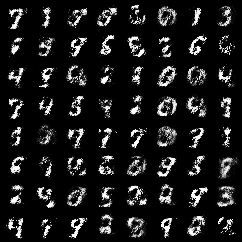



Train Epoch: 23 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007750	Gen_Loss_Avg: 0.013883
Train Epoch: 23 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007232	Gen_Loss_Avg: 0.014100
Train Epoch: 23 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007892	Gen_Loss_Avg: 0.013371
Train Epoch: 23 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007836	Gen_Loss_Avg: 0.013365
Train Epoch: 23 [44928/60000 (100%)]	Disc_Loss_Avg: 0.010581	Gen_Loss_Avg: 0.017543
====> Test set Generate_Loss: 0.0144
====> Test set Discriminator_Loss: 0.0057
Sample of generated images


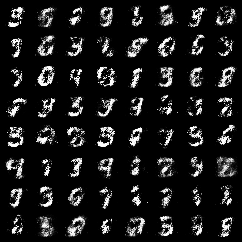



Train Epoch: 24 [12800/60000 (21%)]	Disc_Loss_Avg: 0.008346	Gen_Loss_Avg: 0.013761
Train Epoch: 24 [25600/60000 (43%)]	Disc_Loss_Avg: 0.008147	Gen_Loss_Avg: 0.012628
Train Epoch: 24 [38400/60000 (64%)]	Disc_Loss_Avg: 0.008047	Gen_Loss_Avg: 0.012341
Train Epoch: 24 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007795	Gen_Loss_Avg: 0.012714
Train Epoch: 24 [44928/60000 (100%)]	Disc_Loss_Avg: 0.010466	Gen_Loss_Avg: 0.016915
====> Test set Generate_Loss: 0.0082
====> Test set Discriminator_Loss: 0.0066
Sample of generated images


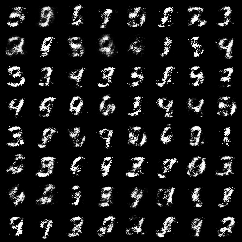



Train Epoch: 25 [12800/60000 (21%)]	Disc_Loss_Avg: 0.008385	Gen_Loss_Avg: 0.011719
Train Epoch: 25 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007582	Gen_Loss_Avg: 0.011773
Train Epoch: 25 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007288	Gen_Loss_Avg: 0.012572
Train Epoch: 25 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007743	Gen_Loss_Avg: 0.012682
Train Epoch: 25 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009911	Gen_Loss_Avg: 0.017200
====> Test set Generate_Loss: 0.0146
====> Test set Discriminator_Loss: 0.0051
Sample of generated images


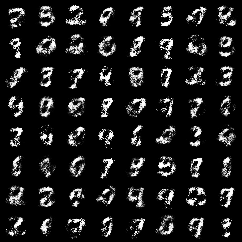



Train Epoch: 26 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006562	Gen_Loss_Avg: 0.013015
Train Epoch: 26 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006639	Gen_Loss_Avg: 0.013697
Train Epoch: 26 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006919	Gen_Loss_Avg: 0.013930
Train Epoch: 26 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006781	Gen_Loss_Avg: 0.013754
Train Epoch: 26 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009439	Gen_Loss_Avg: 0.017838
====> Test set Generate_Loss: 0.0127
====> Test set Discriminator_Loss: 0.0080
Sample of generated images


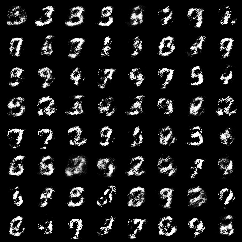



Train Epoch: 27 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007619	Gen_Loss_Avg: 0.013894
Train Epoch: 27 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007676	Gen_Loss_Avg: 0.013655
Train Epoch: 27 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007429	Gen_Loss_Avg: 0.013366
Train Epoch: 27 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007369	Gen_Loss_Avg: 0.013603
Train Epoch: 27 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009551	Gen_Loss_Avg: 0.018279
====> Test set Generate_Loss: 0.0148
====> Test set Discriminator_Loss: 0.0049
Sample of generated images


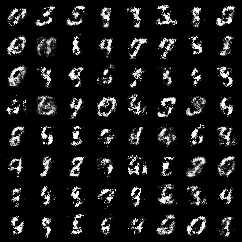



Train Epoch: 28 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007112	Gen_Loss_Avg: 0.015322
Train Epoch: 28 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006557	Gen_Loss_Avg: 0.014534
Train Epoch: 28 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006619	Gen_Loss_Avg: 0.014656
Train Epoch: 28 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006515	Gen_Loss_Avg: 0.014950
Train Epoch: 28 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008641	Gen_Loss_Avg: 0.019883
====> Test set Generate_Loss: 0.0118
====> Test set Discriminator_Loss: 0.0076
Sample of generated images


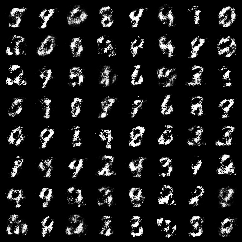



Train Epoch: 29 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007319	Gen_Loss_Avg: 0.013007
Train Epoch: 29 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007670	Gen_Loss_Avg: 0.012555
Train Epoch: 29 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007696	Gen_Loss_Avg: 0.012674
Train Epoch: 29 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007335	Gen_Loss_Avg: 0.012737
Train Epoch: 29 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009583	Gen_Loss_Avg: 0.017136
====> Test set Generate_Loss: 0.0195
====> Test set Discriminator_Loss: 0.0055
Sample of generated images


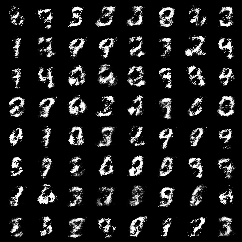



Train Epoch: 30 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006997	Gen_Loss_Avg: 0.013904
Train Epoch: 30 [25600/60000 (43%)]	Disc_Loss_Avg: 0.008073	Gen_Loss_Avg: 0.012734
Train Epoch: 30 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007941	Gen_Loss_Avg: 0.012495
Train Epoch: 30 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007555	Gen_Loss_Avg: 0.012794
Train Epoch: 30 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009847	Gen_Loss_Avg: 0.017134
====> Test set Generate_Loss: 0.0154
====> Test set Discriminator_Loss: 0.0050
Sample of generated images


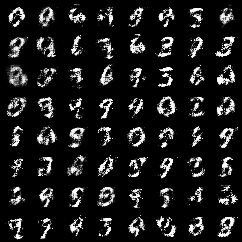



Train Epoch: 31 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006908	Gen_Loss_Avg: 0.013303
Train Epoch: 31 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006994	Gen_Loss_Avg: 0.013987
Train Epoch: 31 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006857	Gen_Loss_Avg: 0.014355
Train Epoch: 31 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007022	Gen_Loss_Avg: 0.014557
Train Epoch: 31 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009535	Gen_Loss_Avg: 0.019384
====> Test set Generate_Loss: 0.0152
====> Test set Discriminator_Loss: 0.0068
Sample of generated images


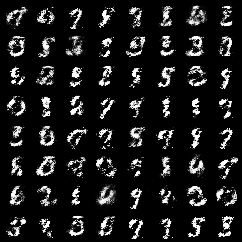



Train Epoch: 32 [12800/60000 (21%)]	Disc_Loss_Avg: 0.008127	Gen_Loss_Avg: 0.016114
Train Epoch: 32 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007612	Gen_Loss_Avg: 0.015334
Train Epoch: 32 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007737	Gen_Loss_Avg: 0.014540
Train Epoch: 32 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007384	Gen_Loss_Avg: 0.014430
Train Epoch: 32 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009986	Gen_Loss_Avg: 0.019013
====> Test set Generate_Loss: 0.0115
====> Test set Discriminator_Loss: 0.0092
Sample of generated images


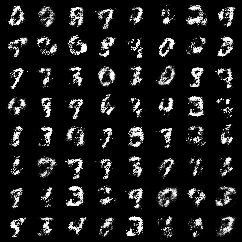



Train Epoch: 33 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007125	Gen_Loss_Avg: 0.014370
Train Epoch: 33 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007115	Gen_Loss_Avg: 0.014109
Train Epoch: 33 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007019	Gen_Loss_Avg: 0.014164
Train Epoch: 33 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007149	Gen_Loss_Avg: 0.014121
Train Epoch: 33 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009783	Gen_Loss_Avg: 0.018648
====> Test set Generate_Loss: 0.0178
====> Test set Discriminator_Loss: 0.0055
Sample of generated images


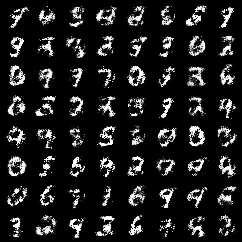



Train Epoch: 34 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006424	Gen_Loss_Avg: 0.013798
Train Epoch: 34 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006187	Gen_Loss_Avg: 0.013750
Train Epoch: 34 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006789	Gen_Loss_Avg: 0.013660
Train Epoch: 34 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006641	Gen_Loss_Avg: 0.013780
Train Epoch: 34 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008781	Gen_Loss_Avg: 0.018200
====> Test set Generate_Loss: 0.0117
====> Test set Discriminator_Loss: 0.0072
Sample of generated images


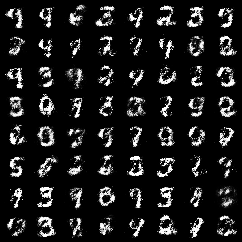



Train Epoch: 35 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006691	Gen_Loss_Avg: 0.014227
Train Epoch: 35 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006342	Gen_Loss_Avg: 0.014322
Train Epoch: 35 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006834	Gen_Loss_Avg: 0.013929
Train Epoch: 35 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006926	Gen_Loss_Avg: 0.013984
Train Epoch: 35 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009042	Gen_Loss_Avg: 0.019282
====> Test set Generate_Loss: 0.0104
====> Test set Discriminator_Loss: 0.0068
Sample of generated images


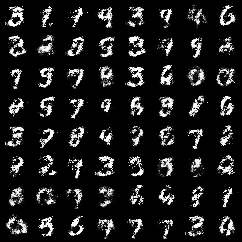



Train Epoch: 36 [12800/60000 (21%)]	Disc_Loss_Avg: 0.008751	Gen_Loss_Avg: 0.015085
Train Epoch: 36 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007855	Gen_Loss_Avg: 0.014881
Train Epoch: 36 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007311	Gen_Loss_Avg: 0.015012
Train Epoch: 36 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007496	Gen_Loss_Avg: 0.014658
Train Epoch: 36 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009832	Gen_Loss_Avg: 0.019314
====> Test set Generate_Loss: 0.0147
====> Test set Discriminator_Loss: 0.0070
Sample of generated images


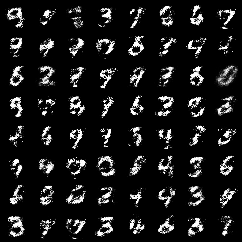



Train Epoch: 37 [12800/60000 (21%)]	Disc_Loss_Avg: 0.008231	Gen_Loss_Avg: 0.012860
Train Epoch: 37 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007577	Gen_Loss_Avg: 0.013809
Train Epoch: 37 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007785	Gen_Loss_Avg: 0.014408
Train Epoch: 37 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007660	Gen_Loss_Avg: 0.014295
Train Epoch: 37 [44928/60000 (100%)]	Disc_Loss_Avg: 0.010085	Gen_Loss_Avg: 0.019084
====> Test set Generate_Loss: 0.0098
====> Test set Discriminator_Loss: 0.0056
Sample of generated images


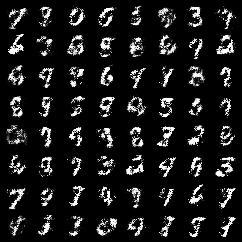



Train Epoch: 38 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006842	Gen_Loss_Avg: 0.013055
Train Epoch: 38 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006916	Gen_Loss_Avg: 0.013779
Train Epoch: 38 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006890	Gen_Loss_Avg: 0.014123
Train Epoch: 38 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006752	Gen_Loss_Avg: 0.013802
Train Epoch: 38 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008907	Gen_Loss_Avg: 0.018367
====> Test set Generate_Loss: 0.0129
====> Test set Discriminator_Loss: 0.0067
Sample of generated images


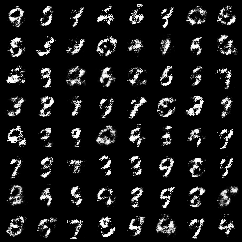



Train Epoch: 39 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007415	Gen_Loss_Avg: 0.013920
Train Epoch: 39 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007659	Gen_Loss_Avg: 0.013197
Train Epoch: 39 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007213	Gen_Loss_Avg: 0.013433
Train Epoch: 39 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007296	Gen_Loss_Avg: 0.013492
Train Epoch: 39 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009980	Gen_Loss_Avg: 0.018096
====> Test set Generate_Loss: 0.0143
====> Test set Discriminator_Loss: 0.0073
Sample of generated images


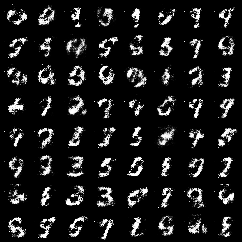



Train Epoch: 40 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006200	Gen_Loss_Avg: 0.014249
Train Epoch: 40 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006318	Gen_Loss_Avg: 0.013810
Train Epoch: 40 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006860	Gen_Loss_Avg: 0.013316
Train Epoch: 40 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006637	Gen_Loss_Avg: 0.013253
Train Epoch: 40 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009098	Gen_Loss_Avg: 0.017651
====> Test set Generate_Loss: 0.0128
====> Test set Discriminator_Loss: 0.0064
Sample of generated images


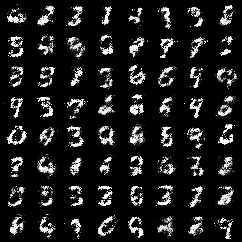



Train Epoch: 41 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006572	Gen_Loss_Avg: 0.013632
Train Epoch: 41 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007110	Gen_Loss_Avg: 0.013013
Train Epoch: 41 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007161	Gen_Loss_Avg: 0.013187
Train Epoch: 41 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007063	Gen_Loss_Avg: 0.013271
Train Epoch: 41 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009743	Gen_Loss_Avg: 0.017434
====> Test set Generate_Loss: 0.0125
====> Test set Discriminator_Loss: 0.0090
Sample of generated images


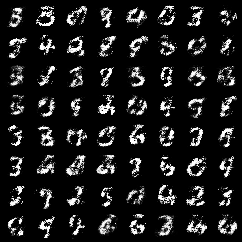



Train Epoch: 42 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007019	Gen_Loss_Avg: 0.014281
Train Epoch: 42 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006637	Gen_Loss_Avg: 0.014378
Train Epoch: 42 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007011	Gen_Loss_Avg: 0.013825
Train Epoch: 42 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007192	Gen_Loss_Avg: 0.013730
Train Epoch: 42 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009884	Gen_Loss_Avg: 0.017945
====> Test set Generate_Loss: 0.0130
====> Test set Discriminator_Loss: 0.0076
Sample of generated images


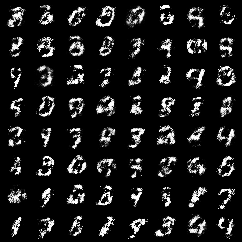



Train Epoch: 43 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007802	Gen_Loss_Avg: 0.011465
Train Epoch: 43 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007177	Gen_Loss_Avg: 0.012066
Train Epoch: 43 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007069	Gen_Loss_Avg: 0.012459
Train Epoch: 43 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007120	Gen_Loss_Avg: 0.012422
Train Epoch: 43 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009471	Gen_Loss_Avg: 0.016537
====> Test set Generate_Loss: 0.0153
====> Test set Discriminator_Loss: 0.0097
Sample of generated images


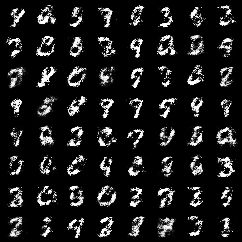



Train Epoch: 44 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006929	Gen_Loss_Avg: 0.014066
Train Epoch: 44 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006589	Gen_Loss_Avg: 0.014878
Train Epoch: 44 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006715	Gen_Loss_Avg: 0.014055
Train Epoch: 44 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006854	Gen_Loss_Avg: 0.013858
Train Epoch: 44 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008879	Gen_Loss_Avg: 0.018596
====> Test set Generate_Loss: 0.0118
====> Test set Discriminator_Loss: 0.0062
Sample of generated images


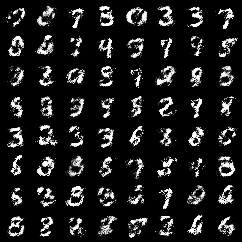



Train Epoch: 45 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006230	Gen_Loss_Avg: 0.013120
Train Epoch: 45 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006546	Gen_Loss_Avg: 0.013146
Train Epoch: 45 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006692	Gen_Loss_Avg: 0.013534
Train Epoch: 45 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006677	Gen_Loss_Avg: 0.013663
Train Epoch: 45 [44928/60000 (100%)]	Disc_Loss_Avg: 0.008995	Gen_Loss_Avg: 0.018028
====> Test set Generate_Loss: 0.0127
====> Test set Discriminator_Loss: 0.0078
Sample of generated images


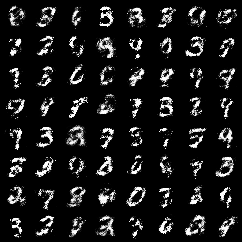



Train Epoch: 46 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007215	Gen_Loss_Avg: 0.012952
Train Epoch: 46 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007264	Gen_Loss_Avg: 0.012808
Train Epoch: 46 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007421	Gen_Loss_Avg: 0.012694
Train Epoch: 46 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007354	Gen_Loss_Avg: 0.012489
Train Epoch: 46 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009755	Gen_Loss_Avg: 0.016645
====> Test set Generate_Loss: 0.0127
====> Test set Discriminator_Loss: 0.0063
Sample of generated images


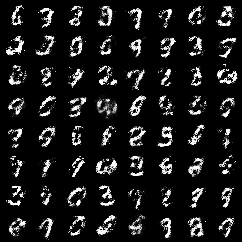



Train Epoch: 47 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006988	Gen_Loss_Avg: 0.013803
Train Epoch: 47 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006765	Gen_Loss_Avg: 0.013680
Train Epoch: 47 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007183	Gen_Loss_Avg: 0.013192
Train Epoch: 47 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007175	Gen_Loss_Avg: 0.013074
Train Epoch: 47 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009624	Gen_Loss_Avg: 0.017138
====> Test set Generate_Loss: 0.0127
====> Test set Discriminator_Loss: 0.0080
Sample of generated images


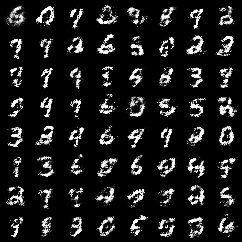



Train Epoch: 48 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006388	Gen_Loss_Avg: 0.013169
Train Epoch: 48 [25600/60000 (43%)]	Disc_Loss_Avg: 0.006491	Gen_Loss_Avg: 0.013069
Train Epoch: 48 [38400/60000 (64%)]	Disc_Loss_Avg: 0.006724	Gen_Loss_Avg: 0.012917
Train Epoch: 48 [51200/60000 (85%)]	Disc_Loss_Avg: 0.006847	Gen_Loss_Avg: 0.012773
Train Epoch: 48 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009369	Gen_Loss_Avg: 0.016935
====> Test set Generate_Loss: 0.0117
====> Test set Discriminator_Loss: 0.0072
Sample of generated images


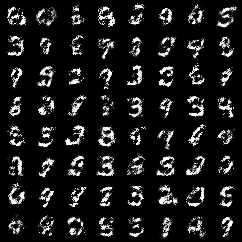



Train Epoch: 49 [12800/60000 (21%)]	Disc_Loss_Avg: 0.007832	Gen_Loss_Avg: 0.012680
Train Epoch: 49 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007729	Gen_Loss_Avg: 0.012781
Train Epoch: 49 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007081	Gen_Loss_Avg: 0.012986
Train Epoch: 49 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007082	Gen_Loss_Avg: 0.013197
Train Epoch: 49 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009491	Gen_Loss_Avg: 0.017749
====> Test set Generate_Loss: 0.0115
====> Test set Discriminator_Loss: 0.0056
Sample of generated images


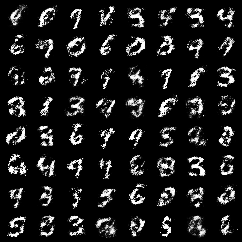



Train Epoch: 50 [12800/60000 (21%)]	Disc_Loss_Avg: 0.006905	Gen_Loss_Avg: 0.013563
Train Epoch: 50 [25600/60000 (43%)]	Disc_Loss_Avg: 0.007621	Gen_Loss_Avg: 0.013048
Train Epoch: 50 [38400/60000 (64%)]	Disc_Loss_Avg: 0.007838	Gen_Loss_Avg: 0.012934
Train Epoch: 50 [51200/60000 (85%)]	Disc_Loss_Avg: 0.007588	Gen_Loss_Avg: 0.012571
Train Epoch: 50 [44928/60000 (100%)]	Disc_Loss_Avg: 0.009774	Gen_Loss_Avg: 0.016992
====> Test set Generate_Loss: 0.0163
====> Test set Discriminator_Loss: 0.0078
Sample of generated images


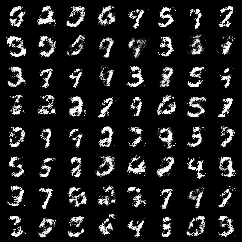

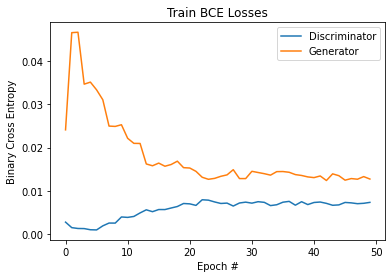

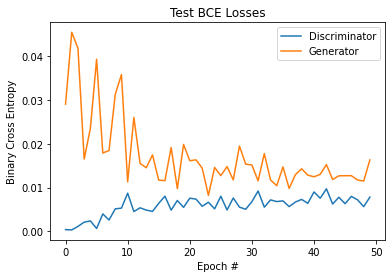

In [6]:
# train and test gan
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()


This explaination is my understanding of the materials represented in the paper [Comparative Study of GAN and VAE](https://www.ijcaonline.org/archives/volume182/number22/chauhan-2018-ijca-918039.pdf) 

**First criteria** to evaluate performance of two generative model
is by comparing mean squared error of both of the models (in our assignment is the average loss).As
VAE is taking pixel values of an image as an input, convert
it into lower dimensional space and then reverse it to generate
original image.The loss of VAE tend to decrease
during training. Where else, loss of GAN is oscillating
at every epoch because of the minimax game.So it is difficult
to measure performance of GAN. Recently various other
evaluation metric is discovered such as inception score and
FID score to more accurately measure performance of GAN.

**second criteria** to compare the two model is by visual
inspection of generated samples.As shown in the results of both assignments, Variational
autoencoder tend to produce blurry images compared to the
GAN.The reason is Decoder output an average value of all
generated images or mean value of distribution. While in GAN this is not the case.
GAN outputs garbage images during some starting epochs as
shown in the results, because it’s loss value is high due to sampling
from random noise.The loss measures how well generator is doing
against the discreminitor.So after some epochs generator loss
increases, but still image quality of generated images increases.
GAN produces high quality images compared to the VAE
but limited varieties of samples. It is because equilibrium point
sometimes may not be reached. Non convergence is a very
difficult problem for GAN.

The GAN produces sharper images while the image is still noisy. The sharpness has been increased in comparison with VAE since we are not restricted to a Normal distribution sampling and we are using a DNN to produce fake images. However, the noise still exist in the output.
In this assignment we can see GAN produced sharper and more varied images in comparison to VAE as explained earlier.
In general the comparios of these two models are really hard since it is highly dependant of the situation and the data provided since both models have their own pros and cons.


**Regarding the mode collapse:**
The example provided in the assignment mentioned that:
Finally, now that we have all of the parts of the GAN framework defined, we can train it. Be mindful that training GANs is somewhat of an art form, as incorrect hyperparameter settings lead to mode collapse with little explanation of what went wrong. Here, we will closely follow Algorithm 1 from Goodfellow’s paper, while abiding by some of the best practices shown in ganhacks. Namely, we will “construct different mini-batches for real and fake” images, and also adjust G’s objective function to maximize logD(G(z)). Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator. So basically we are not dealing with a collapse here in this assignment using this approach.
